# Asymptotic analysis and consistency

**Date: November 2016**

In this notebook we discuss the consistency of decision rules. After a general introduction we restrict attention to empirical loss minimizing decision rules, establish sufficient conditions for consistency to hold and discuss the rate at which the convergence takes place.

 * Consistency of a decision rule states that the corresponding empirical loss converges to the true loss in probability as the sample size grows to infinity.
 
 * In the case of empirical loss minimization, consistency is tightly linked to the uniform law of large numbers that we present in detail.
 
 * We introduce tail and concentration bounds to establish the uniform law of large numbers and analyze the (non-asymptotic) rate at which the convergence takes place.
 

In [3]:
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.stats as stats
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from ipywidgets import interact, FloatSlider

colors = sns.color_palette("Blues")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Introduction

Knowing the true mechanism $P$, while one faces a decision problem $(\mathcal{H},L,\mathcal{A})$, naturally leads to the best in class action $a^{*}_{L, P, \mathcal{A}}$ as the optimal action within the prespecified class $\mathcal{A}$. Although in reality we do not know $P$, it is illuminating to consider this case first as we naturally require that at least with a sufficiently large (in fact, infinite) sample, the true mechanism---from a statistical point of view---can be revealed. The property that guarantees this outcome is the ergodicity of the assumed statistical models.  

This argument suggests to use the best in class action, $a^{*}_{L, P, \mathcal{A}}$, as the optimal large sample solution. In other words, from any sensible decision rule a minimal property to require is that as the sample size grows, the distribution of the decision rule converges to a degenerate distribution concentrated at the point $a^{*}_{L, P, \mathcal{A}}$. 

As an example, consider again the MLE estimator in the coin tossing problem for which the above property is satisfied. The following figure represents how the different confidence bands associated with the action distribution evolve as the sample size goes to infinity. Apparently, for sufficiently large sample sizes, the confidence bands concentrate around the true value, which, due to the correct specification, is equivalent with the best in class action.


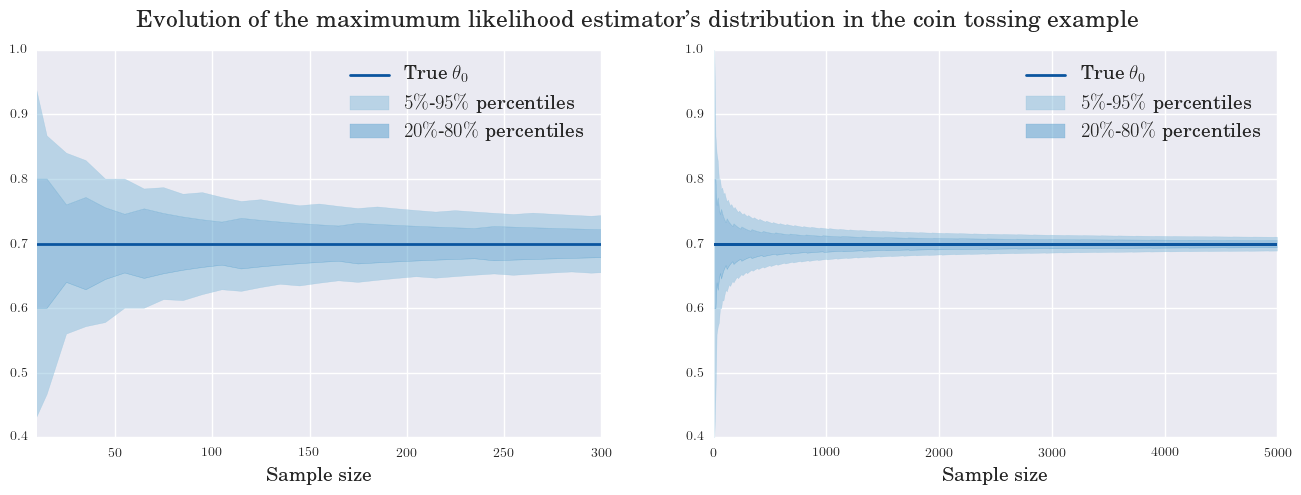

In [4]:
theta0 = .7
N = 5000

sample_sizes = np.arange(5, N, 10)

perc5 = [stats.binom(n, theta0).ppf(.05)/n for n in sample_sizes]
perc25 = [stats.binom(n, theta0).ppf(.2)/n for n in sample_sizes]
perc75 = [stats.binom(n, theta0).ppf(.8)/n for n in sample_sizes]
perc95 = [stats.binom(n, theta0).ppf(.95)/n for n in sample_sizes]

fig, ax = plt.subplots(1, 2, figsize = (16, 5))
fig.suptitle("Evolution of the maximumum likelihood estimator's distribution in the coin tossing example", fontsize = 17)
small_sample = 200
ax[0].fill_between(sample_sizes[:small_sample], perc5[:small_sample], perc25[:small_sample], 
                   color = colors[2], alpha = .5, label = '$5\%$-$95\%$ percentiles')
ax[0].fill_between(sample_sizes[:small_sample], perc25[:small_sample], perc75[:small_sample], 
                   color = colors[3], alpha = .5, label = '$20\%$-$80\%$ percentiles')
ax[0].fill_between(sample_sizes[:small_sample], perc75[:small_sample], perc95[:small_sample], 
                   color = colors[2], alpha = .5)
ax[0].axhline(theta0, color = colors[5], lw = 2, label = r'True $\theta_0$')
ax[0].set_xlim([10, 300])
ax[0].set_ylim([0.4, 1])
ax[0].set_xlabel('Sample size', fontsize = 14)
ax[0].legend(loc='best', fontsize = 14)

ax[1].fill_between(sample_sizes, perc5, perc25, color = colors[2], alpha = .5, label = '$5\%$-$95\%$ percentiles')
ax[1].fill_between(sample_sizes, perc25, perc75, color = colors[3], alpha = .5, label = '$20\%$-$80\%$ percentiles')
ax[1].fill_between(sample_sizes, perc75, perc95, color = colors[2], alpha = .5)
ax[1].axhline(theta0, color = colors[5], lw = 2, label = r'True $\theta_0$')
ax[1].set_ylim([0.4, 1])
ax[1].set_xlabel('Sample size', fontsize = 14)
ax[1].legend(loc='best', fontsize = 14)

ax[1].axhline(theta0, color = colors[5], lw = 2, label = r'True $\theta_0$')
plt.show()

This property of the decision rule is called **consistency**. One of the main objectives of this notebook is to investigate the conditions under which it can be established.   

Given that asymptotically the true $P$ can be learned, a natural question to ask is why not to set $\mathcal{A}$ large enough so as to guarantee $\gamma(P)\in\mathcal{A}$, i.e. a correctly specified model. We will see the sense in which requiring consisteny ties our hands in terms of the "size" of $\mathcal{A}$. 

Although it is hard to provide generally applicable sufficient conditions for consistency, roughly speaking, we can identify two big classes of decision rules for which powerful results are available.

* Bayes decision rules 
* Frequentist decision rules building on the empirical distribution $P_n$, where 

$$P_n(z) : = \frac{1}{n}\sum_{i=1}^{n} \mathbf{1}\{Z_i \leq z\}$$

and $\mathbf{1}\{ A \}$ is the indicator function of the set $A$.

In this notebook we will focus exclusively on the latter approach considering decision rules which assign actions based on minimizing the empirical analog of the population loss. Hence, the procedure is labelled by the name: *empirical loss minimization* or *analog estimation*.


## Consistency of decision rules

To start out our asymptotic inquiry, we first define consistency in a more precise manner than we did before. There are two, slightly different notions depending on the tractability and objectives of the decision problem at hand.  

* **Consistency in terms of the loss function:** a decision rule, $d: \mathcal{S} \mapsto \mathcal{A}$, is consistent in terms of the loss function *relative to $(\mathcal{H}, \mathcal{A})$*, if for all $P \in \mathcal{H}$ the following holds

$$ L(P, d(Z^n)) \ \ \underset{n \to \infty}{\overset{\text{P}}{\rightarrow}} \ \ \inf_{a \in \mathcal{A}}L(P, a) = L\left(P, a^{*}_{L, P,\mathcal{A}}\right) $$

* **Consistency in terms of the action:** a decision rule, $d: \mathcal{S} \mapsto \mathcal{A}$, is consistent in terms of the action *relative to $(\mathcal{H}, \mathcal{A})$*, if for all $P \in \mathcal{H}$ the following holds

$$ P\left\{z^{\infty} \big| \lim_{n \to \infty} m\left(d(z_n), a^*_{L, P, \mathcal{A}}\right) > \epsilon\right\} = 0 \quad \text{for} \quad \forall\epsilon>0, $$

where $m(\cdot, \cdot)$ is a metric on the action space $\mathcal{A}$. The necessary condition---in the case of analog estimators---for this notion of consistency is the identifiability of $a^*_{L, P, \mathcal{A}}$ that we define as follows:

**Identification:** $a^*_{L, P, \mathcal{A}}$ is identified relative to $(P, \mathcal{A})$ if $a^*_{L, P, \mathcal{A}}$ is the unique minimizer of $L(P, \cdot)$ over $\mathcal{A}$.
    
Under identification, the two notions are equivalent. As the above definitions suggest, however, the former is more general to the extent that it also allows for partially identified statistical models. Unless otherwise noted, we will work with consistency in terms of the loss function and call it simply *consistency*.  

In the above definitions, the set of assumed statistical models $\mathcal{H}$ plays a key role: it outlines the set of distributions under which the particular notion of convergence is required. Ideally, we want convergence under the true distribution, however, because we do not know $P$, the "robust" approach is to be as agnostic as possible regarding $\mathcal{H}$. The central insight of statstical decision theory is to highlight that this approach is not limitless: one needs to find a balance between $\mathcal{H}$ and $\mathcal{A}$ to obtain decision rules with good properties. 

Consistency has strong implications for the risk functional in large samples: the degenerate limiting distribution of the decision rule implies that asymptotically the variability of the decision rule vanishes and so

$$ R_{\infty}(P,d) \overset{a.s.}{=} L\left(P, a^{*}_{L, P,\mathcal{A}}\right). $$


##  Uniform law of large numbers

As mentioned before, in this notebook we are focusing on decision rules arising from empirical loss minimization. The basic idea behind this approach is to utilize the consistency definitions directly, but instead of using the quantity $L(P, a)$ that we cannot actually evaluate, subsitute the empirical distribution into the loss function and work with the empricial loss $L(P_n, a)$ instead.

*Remark:* The empirical loss is not defined, if $P_n$ is not in the domain of $L$---as is the case, for example, with non-parametric density estimation. Then, one has to either extend the domain of $L$ or map $P_n$ to the original domain of the loss function $L$. An excellent discussion can be found in Manski (1988). 

Given that the loss function is continuous in its first argument, the law of large numbers (LLN), accompanied with the continuous mapping theorem, implies

$$ L(P_n, a) \quad  \underset{n \to \infty}{\to} \quad L(P, a) $$

that is, for a *fixed action* $a$, the emprical loss converges to the true loss as the sample size goes to infinity. Notice, however, that consistency 

- is not a property of a given action, but a whole decision rule, more precisely, it is about the convergence of the sequence $\{d(z^n)\}_{n\geq 1} \subseteq \mathcal{A}$ 
- requires convergence to the *minimum* loss (within $\mathcal{A}$) that we ought to take into account while generating decision rules 
 
In the spirit of the analogy principle, decision rules minimizing the *empirical loss* can be written as follows 

$$ d(z^n) := \arg\min_{a\in\mathcal{A}} L(P_n, a), $$

where the dependence on the sample is embodied by the empirical distribution $P_n$. The heuristic idea is that because $d(z^n)$ minimizes $L(P_n, \cdot)$, and $P_n$ converges to $P$, then "ideally" $d(z^n)$ should go to $a^{*}_{L, P, \mathcal{A}}$, the minimizer of $L(P, a)$, as the sample size grows. 

What do we need to ensure this argument to hold? First, notice that the standard law of large numbers is inadequate for this purpose. In order to illustrate this, we turn now to a concept closely related to empirical loss minimization: generalization.

#### Generalization

Using the empirical loss as a substitute for the true loss while determining the decision rule, a critical question is how much error do we introduce with this approximation. The object of interest regarding this question is the *excess loss* for a given action $a$ and sample size $n$

$$ \left| L(P_n, a) - L(P, a) \right|. $$

We say that the action $a$ **generalizes** well from a given sample $z^n$, if the corresponding excess loss is small. Taking the absolute value is important: $L(P_n, a)$ can easily be smaller than $L(P, a)$ as it is in the case of overfitting. 

Due to $P_n$'s dependence on the particular sample, however, the excess loss (for a given $a$) is a random variable. It might be small for a given sample $z^n$, but what we really need in order to justify the method of empricial loss minimization is that the excess loss is small for "most samples", or more precisely


$$ P\left(z^n : \left| L(P_n, a) - L(P, a) \right| > \delta \right) \quad \text{is small.} $$

Since $L$ is continuous in its first argument and $P_n \to P$, this so called **tail probability** converges to zero for any fixed $a\in\mathcal{A}$. The figure below displays such tail probabilities for the MLE estimator in the coin tossing example (with quadratic loss) for different actions as functions of the sample size.  

One can see that even though the tail probabilities converge to $0$ for all $a\in\mathcal{A}$, the *rate of convergence* depends on the particular $a$. In other words, $\forall \varepsilon>0$ and $\forall a\in\mathcal{A}$, there is an *action dependent* minimum sample size $N(a, \varepsilon, \delta)$, that we need in order to guarantee that the corresponding tail probability falls below $\varepsilon$.  

Suppose now that we have a decision rule and look at its induced sequence of actions $\{a_n\}_{n\geq 1}$ for a fixed realization $z^{\infty}$. Again, for consistency, we need the associated sequence of tail probabilities converging to zero for "most $z^{\infty}$". 

* When the set $\mathcal{A}$ has finitely many elements, this is not a problem: we can simply define
$$N(\varepsilon, \delta) : = \max_{a\in\mathcal{A}} N(a, \varepsilon, \delta)$$
and observe that for all $n\geq N(\varepsilon, \delta)$, the tail probabilities are smaller than $\varepsilon$, $\forall a\in \{a_n\}_{n\geq 1} \subseteq \mathcal{A}$.
 
* However, because the critical sample size $N(a, \varepsilon, \delta)$ depends on the action, if $\mathcal{A}$ is "too big", it is possible that there is no $n$ so that $n > N(a_n, \varepsilon, \delta)$, hence $L(P_n, a_n)$ may never approach $L(P, a_n)$.

A possible approach to avoid this complication is to require the existence of an integer $N(\varepsilon, \delta)$ *independent of $a$*, such that for all sample sizes larger than $N(\epsilon, \delta)$ 

$$ \lim_{n\to \infty} P\left\{\sup_{a \in\mathcal{A}} \left| L(P_n, a) - L(P, a) \right| > \delta\right\} = 0. $$

This notion is called the **uniform law of large numbers** referring to the fact that the convergence is guaranteed simultaneously for all actions in $\mathcal{A}$.


In [5]:
def relative_entropy(prob0, theta0, a):
    return prob0 * np.log(theta0/a) + (1 - prob0) * np.log((1 - theta0)/(1 - a))

def loss_distribution(l, aa, loss_func, true_dist, upper):
    """
    Uses the formula for the change of discrete random variable. It takes care of the 
    fact that the loss is not monotone.
    """
    eps = 1e-10
    n, theta0 = true_dist.args
    
    if loss_func == 'relative_entropy':
        frac = sp.optimize.bisect(lambda x: relative_entropy(x, theta0, aa) - l, a = eps, b = 1 - eps)
    
    elif loss_func == 'quadratic':
        frac = (l - aa**2)/((1 - aa)**2 - aa**2)

    if aa < .5: #theta0:
        if upper:
            return 1 - true_dist.cdf(frac * n)
        else:
            return true_dist.cdf(frac * n)
    else:
        if upper:
            return true_dist.cdf(frac * n)
        else:
            return 1 - true_dist.cdf(frac * n)
        
def prob(l, a, true_dist):
    n, theta0 = true_dist.args
    #true = relative_entropy(theta0, theta0, a)
    true = theta0 * (1 - a)**2 + (1 - theta0) * a**2
    
    upper = true + l
    lower = true - l
    
    first = loss_distribution(upper, a, "quadratic", true_dist, upper = True)
    second = loss_distribution(lower, a, "quadratic", true_dist, upper = False)
    
    return first + second

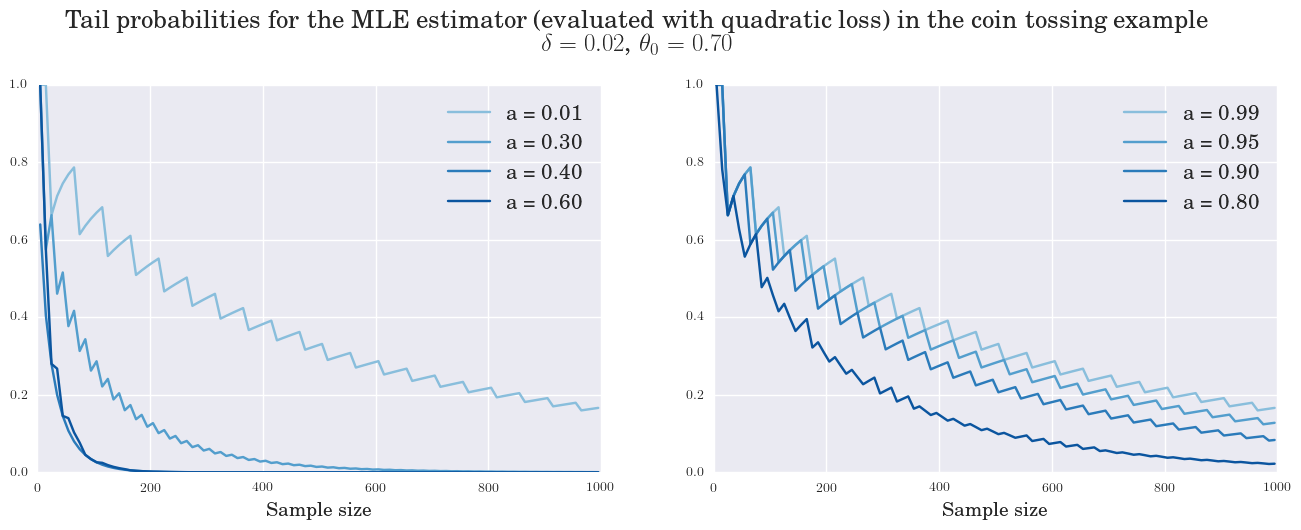

In [6]:
sample_size = np.arange(5, 1000, 10)
action_grid1 = [.01, .3, .4, .6]
action_grid2 = [.99, .95, .9, .8]
delta = .02

fig, ax = plt.subplots(1, 2, figsize = (16, 5))
fig.suptitle('Tail probabilities for the MLE estimator (evaluated with quadratic loss) in the coin tossing example \n' + 
             r"$\delta = {:1.2f}$,  $\theta_0 = {:1.2f}$".format(delta, theta0), 
            fontsize = 18, y = 1.05)
for i, a in enumerate(action_grid1):
    ax[0].plot(sample_size, [prob(delta, a, stats.binom(nn, theta0)) for nn in sample_size], 
               label = r'a = {:1.2f}'.format(a), color = colors[2 + i])
ax[0].legend(loc = 'best', fontsize = 15)
ax[0].set_xlabel('Sample size', fontsize = 14)

for i, a in enumerate(action_grid2):
    ax[1].plot(sample_size, [prob(delta, a, stats.binom(nn, theta0)) for nn in sample_size], 
               label = r'a = {:1.2f}'.format(a), color = colors[2 + i])
ax[1].legend(loc = 'best', fontsize = 15)
ax[1].set_xlabel('Sample size', fontsize = 14)
plt.show()

### A special case (plug-in estimators)

There are special cases where we do not need to worry about uniformity. When the true loss function has a minimizer $a^{*}_{L, P, \mathcal{A}}$ that admits a closed form in the sense that it can be expressed as a continuous function of $P$, the empirical loss minimizer is simply a sample analog of $a^{*}_{L, P, \mathcal{A}}$. Effectively, there is no need to minimize the emprical loss, so in spirit, it is as if we kept a particular action fixed. In these cases the standard LLN is sufficient to establish consistency. 
 
* *Sample mean:* 
Consider the quadratic loss function with the feature $\gamma(P) = E[Z]$, i.e. the loss is $L(P,a) = E[(a - E[Z])^2]$. Evidently, the minimizer of this quantity is $E[Z]$. Although we could proceed by minimizing the empricial loss to derive the decision rule, we do not need to do that, because we know up front that it is equal to the sample analog of $E[Z]$. The decision rule is the plug-in estimator $d(z^n) = \frac{1}{n}\sum_{i=1}^{n}z_i$.
       
* *OLS estimator:*
Suppose that $Z=(Y, X)$ and consider the quadratic loss $L(P, a) = E[(Y-a)^2 | X]$, where $E[\cdot | X]$ is the expectation operator conditioned on $X$. Assume that $(Y, X)$ follows a multivariate normal distribution, then the minimizer of $L$ is given by $a = E\left[(X'X)^{-1}\right]E[X'Y]$. Consequently, there is no need for explicit minimization, we can use the least squares estimator as a plug-in estimator for $a$.

More generally, as the empirical loss minimizer is itself a functional, if the "argmin" functional can be shown to be continuous on the space of empirical loss functions, then an application of the continuous mapping theorem together with the Glivenko-Cantelli theorem (i.e. $\lVert P_n - P \rVert_{\infty} \to 0$) would yield consistency. For reference, see van der Vaart (2000).


## Uniform law of large numbers and consistency

In more general nonlinear models, however, $a^{*}_{L, P, \mathcal{A}}$ has no analytical form, so we cannot avoid minimizing the empirical loss in order to derive the decision rule. In these cases, guaranteeing the validity of uniform convergence becomes essential. In fact, it can be shown that consistency of any decision rule that we derive by minimizing some empirical loss function, is *equivalent with* the uniform LLN. 

**Vapnik and Chernovenkis (1971)**: Uniform convergence 
$$ \lim_{n\to \infty} P\left\{\sup_{a \in\mathcal{A}} \left| L(P_n, a) - L(P, a) \right| < \varepsilon\right\}= 1 $$

for all $\varepsilon >0$ is *necessary and sufficient* for consistency of decision rules arising from empirical loss minimization over $\mathcal{A}$.

Although this characterization of consistency is theoretically intriguing, it is not all that useful in practice unless we find easy-to-check conditions which ensure uniform convergence of empirical loss over a particular function class $\mathcal{A}$. As a preparation to discuss these conditions, introduce first some notation

Almost all loss functions used in practice can be cast in the structure taking the following form. There exist 

* $l : \mathcal{A}\times Z \mapsto R^{m}$ and 
* a *continuous* $r : R^{m} \mapsto R_+$ such that
    
$$ L(P, a) = r\left( \int_Z l(a, z)dP (z)\right) $$

Continuity of $r$ implies that in order to establish consistency it is enough to investigate the properties of the limit 

$$ P\left( \sup_{a\in\mathcal{A}} \left| \int_Z l(a, z)dP_n (z) - \int_Z l(a, z)dP(z)\right| > \varepsilon \right) \quad  \underset{n \to \infty}{\to} \quad  0 \quad\quad \forall \varepsilon > 0$$ 

Formally, this requires that the class of functions $\left\{l(a, \cdot) : a \in \mathcal{A} \right\}$ is a **Glivenko-Cantelli class** for $P$.

---------------------
**Definition (Glivenko-Cantelli class):** Let $\mathcal{F}$ be a class of integrable real-valued functions of the random variable $Z$ having distribution $P$. Consider the random variable 

$$ \Vert P_n - P \Vert_{\mathcal{F}} : = \sup_{f\in\mathcal{F}} \left| \frac{1}{n}\sum_{i=1}^{n} f(z_i) - E[f] \right| $$

We say that $\mathcal{F}$ is a Glivenko-Cantelli class for $P$, if $\Vert P_n - P \Vert_{\mathcal{F}}$ converges to zero in probability as $n\to\infty$.

-----------------

A useful decomposition highlights the importance of the uniform law of large numbers in the case of empirical loss minimization. We would like to know the difference between the true loss of our estimator and the true loss of the best in class action. Denote the expectation operator by $\int_Z l(a, z)dP(z) =: P l_a$, the analog estimate as $\hat{a} = d(z^n)$ and the best in class action as $a^*$.

$$ Pl_{\hat{a}} - Pl_{a^*} = (Pl_{\hat{a}} - P_n l_{\hat{a}}) + (P_n l_{\hat{a}} - P_n l_{a^*})  + (P_n l_{a^*} - P l_{a^*}) $$

The last term on the right hand side is governed by the Law of Large Numbers, the middle term is necessarily weakly positive by definition of the empirical loss minimizing decision rule, and the first term is governed by the Uniform Law of Large Numbers. Hence, if we want to control the excess risk -- the left hand side -- then we necessarily have to control the right hand side.


### Sufficient conditions

Variables of the form $\Vert P_n - P \Vert_{\mathcal{F}}$ are ubiquitos in statistics and econometrics and there are well-known sufficient conditions that guarantee its convergence.

* For parametric estimation, probably the most widely used (at least in econometrics) sufficient condition includes the following three assumptions (or some form thereof). Suppose that the action space $\mathcal{A}$ is indexed by a finite dimensional vector $\theta\in\Theta \subset \mathbb{R}^{p}$. If
  * $\Theta$ is *compact*
  * $l(\theta, z)$ is a function such that $l(\cdot, z)$ is *continuous* on $\Theta$ with probability one
  * $l(\theta, z)$ is *dominated* by a function $G(z)$, i.e. $|l(\theta, z)|\leq G(z)$ for all $\theta\in\Theta$, such that $E[G]<\infty$

then $\mathcal{L} := \left\{l(a, \cdot) : a \in \mathcal{A} \right\}$ is a Glivenko-Cantelli class for $P$ and so the estimator that it represents is consistent. Among others, these assumptions are the bases for consistency of the (Quasi-)Maximum Likelihood (White, 1994) and the Generalized Method of Moments estimators (Hansen, 1982).  

* A somewhat different approach focuses on the "effective size" of the class $\left\{l(a, \cdot) : a \in \mathcal{A} \right\}$ and frames sufficient conditions in terms of particular complexity measures such as the Vapnik-Chernovenkis dimension or Rademacher complexity. The idea is to find tail bounds for the probability that $\Vert P_n - P \Vert_{\mathcal{L}}$ deviates substantially above the complexity of $\mathcal{L}$. In the following section we present the main ideas behind the derivation of non-asymptotic tail bounds.
 
**An interesting necessary condition:** If $\mathcal{L}$ is a collection of indicator functions and the data generating process is assumed to be i.i.d., a necessary and sufficient condition for distribution free uniform convergence is that the Vapnik-Chervonenkis complexity of $\mathcal{L}$ is finite.


## Non-asymptotic bounds

We saw that in order to establish consistency for analog estimators we had to establish uniform convergence of the empirical loss to the true loss over the entire action space. In this section, we present an approach to the laws of large numbers (uniform or "standard"), which builds on a finite sample perspective.

For a given finite sample size, we study the concentration of *empirical random variables* around their means. We use the shorthand "empirical random variable" to refer to the sample average of random variables highlighting their connection to empirical processes. Ensuring that the empirical random variable goes to a degenerate distribution on its mean---"perfectly" concentrates around it---will establish the law of large numbers.

Studying concentration and tail bounds for each finite sample size has the advantage that we will get rates of convergence as a byproduct. The rate of convergence will give us information regarding the minimum sample size above which the asymptotic results are going to be good approximations.

First, we study how the concentration measures work for a single random variable. This is going to parallel the law of large numbers. Second, we study concentration measures taking place uniformly over a class of random variables. This is going to parallel the uniform law of large numbers.


### Tail and Concentration Bounds

Throughout the section we should keep in mind the characterization of consistency in the case of analog estimators. This was equivalent to uniform convergence which we repeat here

$$ P\left( \sup_{a\in\mathcal{A}} \left| \int_Z l(a, z)dP_n (z) - \int_Z l(a, z)dP(z)\right| > \varepsilon \right) \quad  \underset{n \to \infty}{\to} \quad  0 \quad\quad \forall \varepsilon > 0. $$

Denote the functions of the random variable $Z$ as $l_a(Z):=l(a, Z)$ and refer to the transformed random variable as $l_a$. Then, the centered empirical random variable for a given action is 


$$ (P_n l_a - P l_a) := \int_Z l(a, z)dP_n (z) - \int_Z l(a, z)dP(z). $$

Note, that this is a random variable because the empirical distribution is a function of the random sample. $Pl_a$ is just the expectation of $l_a(Z)$ and hence it is a non-random scalar. Next we study the tail probabilities of these centered random variables.


### Markov's inequality

Markov's inequality states that for any non-negative scalar random variable $Z$ and $t>0$ we have 

$$ P\{Z \geq t\}\leq \frac{\mathbb{E}[Z]}{t}. $$

The idea behind this inequality is fairly simple and in fact it follows from the following obvious inequality 

$$ \mathbf{1}\{Z\geq t\}\leq \frac{Z}{t} $$

illustrated by the figure below. Clearly, for any probability measure $P$ over $Z$ with a finite first moment Markov's inequality can be established.


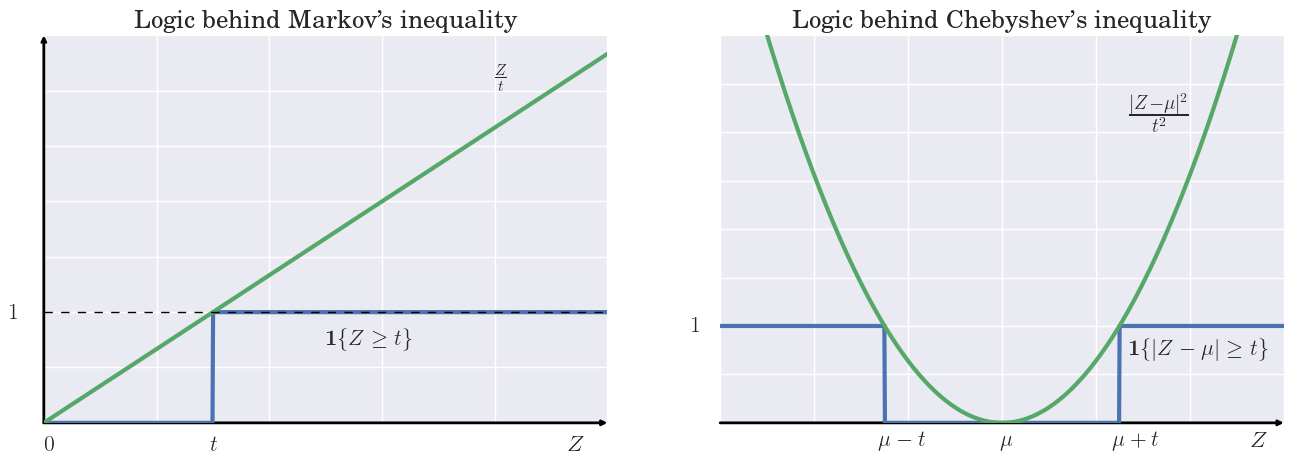

In [7]:
z = np.linspace(0, 10, 1000)
t = 3

f1 = (z >= t)
f2 = z / t

colors = sns.color_palette()

fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax[0].add_artist(ConnectionPatch(xyA=(0, 0), xyB=(10, 0), coordsA="data", coordsB="data",
                                 arrowstyle="->", mutation_scale=10, lw = 2))
ax[0].add_artist(ConnectionPatch(xyA=(0, 0), xyB=(0, 3.5), coordsA="data", coordsB="data",
                                 arrowstyle="->", mutation_scale=10, lw = 2))

ax[0].plot(z, f1, color = colors[0], lw = 3, label = r'$\mathbf{1}\{Z \geq t\}$')
ax[0].plot(z, f2, color = colors[1], lw = 3, label = r'$\frac{Z}{t}$')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].text(9.3, -.25, r'$Z$', fontsize = 17)
ax[0].text(8, 3, r'$\frac{Z}{t}$', fontsize = 16)
ax[0].text(5, .7, '$\mathbf{1}\{Z \geq t\}$', fontsize = 16)
ax[0].text(t - .05, -.25, '$t$', fontsize = 16)
ax[0].text(0, -.25, '$0$', fontsize = 16)
ax[0].text( -.6, .93, r'$1$', fontsize = 16)
ax[0].axhline(1, linestyle = '--', color = 'k', lw = 1)
ax[0].set_title('Logic behind Markov\'s inequality', fontsize=18)

t = 2.5
mu = 2
z = np.linspace(mu - 6, mu + 6, 1000)

g1 = (z >= mu + t) + (z <= mu - t)
g2 = ((z - mu) / t)**2

ax[1].add_artist(ConnectionPatch(xyA=(mu - 6, 0), xyB=(mu + 6, 0), coordsA="data", coordsB="data",
                                 arrowstyle="->", mutation_scale=10, lw = 2))
ax[1].plot(z, g1, color = colors[0], lw = 3, label = r'$\mathbf{1}\{Z \geq t\}$')
ax[1].plot(z, g2, color = colors[1], lw = 3, label = r'$Z/t$')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].text(mu + 5.3, -.25, r'$Z$', fontsize = 17)
ax[1].text(4.7, 3, r'$\frac{|Z-\mu|^2}{t^2}$', fontsize = 20)
ax[1].text(4.7, .7, r'$\mathbf{1}\{|Z -\mu |\geq t\}$', fontsize = 16)
ax[1].text(mu - .05, -.25, r'$\mu$', fontsize = 16)
ax[1].text(mu + t - .15, -.25, r'$\mu + t$', fontsize = 16)
ax[1].text(mu - t - .15, -.25, r'$\mu - t$', fontsize = 16)
ax[1].text(mu - 6 - .6, .93, r'$1$', fontsize = 16)
ax[1].set_title('Logic behind Chebyshev\'s inequality', fontsize=18)
ax[1].set_ylim([0, 4])
plt.show()

It follows from Markov's inequality that for any strictly monotonically increasing non-negative function $\phi$ and any random variable $Z$ (not necessarily non-negative) we have that

$$ P\{Z \geq t\} = P\{\phi(Z) \geq \phi(t)\} \leq \frac{\mathbb{E}[\phi(Z)]}{\phi(t)}. $$

Taking the centered random variable $| Z - \mathbb{E}[Z]|$ and $\phi(x) = x^q$ for some $q>0$ leads to tail bounds expressed in terms of the moments of the random variable $Z$.

$$ P\{| Z - \mathbb{E}[Z]| \geq t\} \leq \frac{\mathbb{E}[| Z - \mathbb{E}[Z]|^q]}{t^q}. $$

Note that for $q = 2$, this form delivers the Chebyshev inequality (see the right panel of the Figure). This approach to bounding tail probabilities is quite general. Controlling higher order moments leads to (weakly) tighter bounds on the tail probabilities.


### Chernoff bounds

A related idea is at the core of the so called Chernoff bound. For that one takes the transformation $\phi(x) = e^{\lambda x}$ applied to the centered random variable $(Z - \mathbb{E}[Z])$ which yields

$$ P\{(Z - \mathbb{E}[Z]) \geq t\} \leq \frac{\mathbb{E}\left[e^{\lambda(Z - \mathbb{E}[Z])}\right]}{e^{\lambda t}}. $$

Minimizing the bound over $\lambda$ (provided the moments exist) would lead us to the Chernoff bound

$$ \log P\{(Z - \mathbb{E}[Z]) \geq t\} \leq - \sup_{\lambda} \left\{\lambda t - \log \mathbb{E}\left[e^{\lambda(Z - \mathbb{E}[Z])}\right]\right\} $$

Before applying directly the developed tail bounds to the random variable defined above---$(P_n l_a - P l_a)$---we exploit the fact that it is a sum of random variables.


### Hoeffding bounds

Suppose first that the sample $z^n$ is generated by an iid process and recall that $(P_n l_a - P l_a) = \frac{1}{n}\sum_{i=1}^n l_a(Z_i) - \mathbb{E}[l_a(Z)]$. Bounding the tails via Chernoff's method yields 

$$ P\left\{\left(\frac{1}{n}\sum_{i=1}^n l_a(Z_i) - \mathbb{E}[l_a(Z)]\right) \geq t\right\} \leq \frac{\mathbb{E}\left[e^{\lambda \frac{1}{n}\sum_{i=1}^n \left(l_a(Z_i) - \mathbb{E}[l_a(Z)]\right)}\right]}{e^{\lambda t}} = e^{-\lambda t} \prod_{i=1}^n \mathbb{E}\left[e^{\lambda \frac{1}{n}\left(l_a(Z_i) - \mathbb{E}[l_a(Z)] \right)} \right] $$

where the equality follows from independece. Hence, the problem of deriving a tight bound boils down to bounding the moment generating function of 

$$ \frac{1}{n}\left(l_a(Z_i) - \mathbb{E}[l_a(Z)] \right). $$

For our purposes a particularly important class of random variables are the so called sub-Gaussian variables.

**Definition.** A random variable $Z$ is called sub-Gaussian if there is a positive number $\sigma$ such that

$$ \mathbb{E}\left[e^{\lambda \left(Z - \mathbb{E}[Z] \right)} \right] \leq e^{\sigma^2\lambda^2/2}$$

for all $\lambda \in \mathbb{R}$.

Remark: A Guassian variable with variance $\sigma^2$ is sub-Gaussian with parameter $\sigma$. There are other non-Guassian random variables which are sub-Gaussian -- for example all bounded random variables, Rademacher variables

**Theorem.** (Hoeffding) Let the variables $l_a(Z_i)$ be iid and sub-Gaussian with parameter $\sigma$. Then, for all $t>0$ we have that

$$P\left\{\left|\frac{1}{n}\sum_{i=1}^n l_a(Z_i) - \mathbb{E}[l_a(Z)]\right| \geq t\right\} \leq 2\exp\left\{-\frac{t^2 n}{2\sigma^2}\right\}.$$

For a *single action $a$* we see how the Hoeffding inequality is at the core of the law of large numbers. In fact it gives an exponential rate of convergence.

However, in order to talk about concentration properties of decision rules, $d: \mathcal{S}\mapsto\mathcal{A}$ we would like to make statements about tail probabilities uniformly over a class of actions. This leads us to uniform bounds.


### Uniform Tail and Concentration Bounds for classes of finite cardinality

As a first simple example we consider the case when there are only finitely many actions in the set $\mathcal{A}$. Denote the cardinality by $\#\mathcal{A}=A_k$. A conservative estimate of the uniform tail bound in this case is the union bound.

**Corollary.** (Hoeffding union bound) Let the variables $\{l_a(Z_i): a=1,\ldots, A_k\}$ be iid and sub-Gaussian with common parameter $\sigma$. Then, for all $t > 0$ we have that

$$ P\left\{\sup_{a\in\mathcal{A}}\left| \frac{1}{n}\sum_{i=1}^n l_a(Z_i) - \mathbb{E}[l_a(Z)]\right| \geq t \right\} \leq \sum_{a = 1}^{A_k} P\left\{\left|\frac{1}{n}\sum_{i=1}^n l_a(Z_i) - \mathbb{E}[l_a(Z)]\right| \geq t \right\} \leq A_k 2\exp\left\{-\frac{t^2 n}{2\sigma^2}\right\}. $$

The difference between the uniform and individual Hoeffding bounds is just a scaling factor, $A_k$. In the following, our objective is to extend the above analysis to action spaces with infinite cardinality. To this end, we need to find a better "measure" of the size of the action space than its cardinality. Next, we introduce one such complexity measure which proves to be extremely useful in the case of characterizing tail bounds of analog estimators.


## Uniform tail bounds for classes of infinite cardinality - Rademacher complexity

In order to work with sets of infinitely many functions we would like to capture the size of these infinite sets for the purpose of statistical analysis. One such measure of statistical size is the Rademacher complexity of a class of real-valued functions.

For a given realization of a sample, $z^n$, of size $n$ consider the the set of vectors

$$ \mathcal{L}(z^n) := \left\{ (l(z_1), \ldots, l(z_n)) \in \mathbb{R}^n \mid l \in \mathcal{L} \right\}.$$

This is the number of ways one can label points of a sample using functions in the class $\mathcal{F}$. The **empirical Rademacher complexity of $\mathcal{L}$** for fixed $z^n$ is defined as

$$ \mathcal{R}\left(\frac{\mathcal{L}(z^n)}{n} \right) := \mathbb{E}_{\epsilon}\left[\sup_{l\in \mathcal{L}}\Big| \frac{1}{n}\sum_{i=1}^n \epsilon_i l(z_i) \Big| \right] $$

where the expectation is taken with respect to the iid Rademacher random variables, $\epsilon_i$ which take value in $\{-1, 1\}$ with equal probability.

The **Rademacher complexity of $\mathcal{L}$** at sample size $n$ is defined as

$$ \mathcal{R}_n\left(\mathcal{L}\right) := \mathbb{E}_{Z^n} \Big[\mathcal{R}\left(\frac{\mathcal{L}(z^n)}{n} \right)\Big] $$.

The Rademacher complexity has an intuitive interpretation. It is the average of the maximum correlations between the vectors $\big(l(z_1), \ldots, l(z_n)\big)$ and the pure noise vector $\big(\epsilon(z_1), \ldots, \epsilon(z_n)\big)$. The function class $\mathcal{L}$ is too "large" for statistical purposes, if we can always choose a function, $l\in\mathcal{L}$ that has high correlation with a randomly drawn noise vector (Wainwright, 2015).


### Illustration of Rademacher complexity

In the following we consider two classes of functions. Although both classes can be parametrized by a *single* free parameter, we will see that one of them has drastically smaller Rademacher complexity than the other. 

#### Coin tossing example revisited

Consider again the coin tossing example with the quadratic loss function discussed before. In this case $Z^n$ is an iid sample from a Binomial distribution parametrized with $p\in[0, 1]$. The class of functions is given by the quadratic class

$$ \mathcal{L} := \{l_a : l_a(z) = (z - a)^2, \ \  a \in [0, 1]\subseteq \mathbb{R}\} $$

Below we see how the Rademacher compexity of $\mathcal{L}$ converges to zero as the sample size grows to infinity.


In [8]:
# Compute the Rademacher compelxity for the coin tossing example
n, k = 10, 6

def given_epsilon_path(n3, n4, n, k):
    n1 = n - k - n3
    n2 = k - n4
    
    diff1 = n1 - n3
    diff2 = n2 - n4
    
    term1 = abs(diff1/n)
    term2 = abs(diff2/n)
    
    if diff1 + diff2 != 0:
        term3 = abs((diff2/(diff1 + diff2))**2 * (diff1/n) + (diff1/(diff1 + diff2))**2 * (diff2/n))
    else:
        term3 = 0
        
    return max(term1, term2, term3)
    
    
def empirical_rademacher(n, k):
    prob_row = stats.binom(k, .5).pmf(np.arange(k + 1)).reshape(k + 1, 1)
    prob_col = stats.binom(n - k, .5).pmf(np.arange(n - k + 1)).reshape(1, n - k + 1)    
    prob_matrix = prob_row * prob_col
    
    emp_rad = 0
    for i in range(k + 1):               # loop for n4
        for j in range(n - k + 1):       # loop for n3
            emp_rad += given_epsilon_path(j, i, n, k) * prob_matrix[i, j]
    
    return emp_rad

def rademacher_complexity(n): 
    true_prob = stats.binom(n, theta0).pmf(np.arange(n + 1)).reshape(n + 1, 1)
    rademacher = 0
    
    for i in range(n + 1):
        rademacher += true_prob[i] * empirical_rademacher(n, i)
    
    return rademacher[0]

#def rademacher_bound(n, delta):
#    B = 1
#    arg = -(n * (delta - 2 * rademacher_complexity(n))**2/(8 * B**2))
    
#    return 2 * np.exp(arg)

In [9]:
samples = np.arange(10, 1000, 50)
RC = [rademacher_complexity(n) for n in samples]

(0, 0.25)

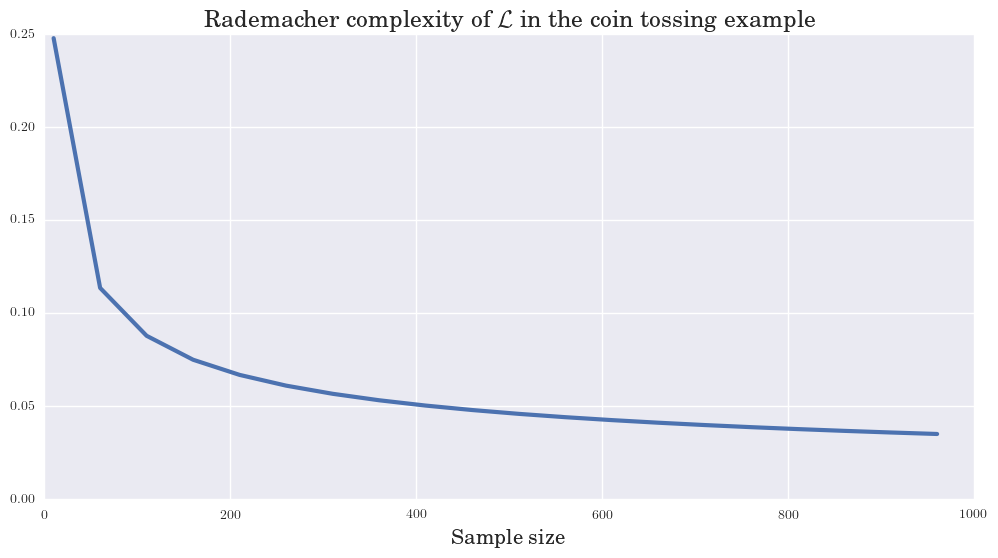

In [10]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(samples, RC, lw = 3)
ax.set_title("Rademacher complexity of $\mathcal{L}$ in the coin tossing example", fontsize = 17)
ax.set_xlabel('Sample size', fontsize = 15)
ax.set_ylim([0, .25])

#### Sinusoid classification

Next, we consider a set of classifier functions where the classification boundary is given by a sine function.

$$ \mathcal{L} := \Big\{ \mathbb{1}\{sin(az) \geq 0\} - \mathbb{1}\{sin(az) < 0\} : a \in \mathbb{R}_+ \Big\} $$

For better illustration, in this case we consider the empirical Rademacher complexity for a fixed realization of the sample, $z^n$.

*Remark:* In order to have a closed form solution for the optimal classifier we are selecting the sample at convenient points. This is without loss of generality and useful for illustrative purposes.


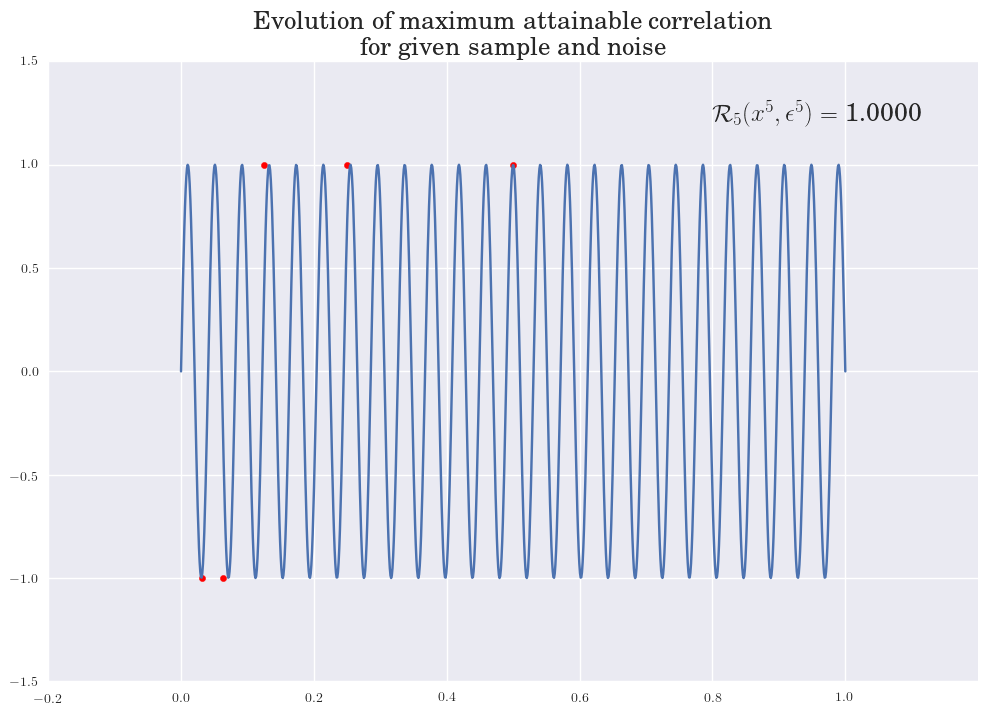

In [11]:
n_slider = FloatSlider(min = 2, max = 20 , step = 1, value = 5)

def rademacher(n):
    '''Generates N Rademcaher random variables.'''
    aux = np.random.rand(int(n))
    return np.array([1 if x >= .5 else -1 for x in aux])

@interact(n = n_slider)
def rademacher_example(n):
    fig, ax = plt.subplots(figsize = (12, 8))

    x = np.array([2**(-(i+1)) for i in range(int(n))])
    y = rademacher(int(n))

    y_aux = np.array([1 if r > 0 else 0 for r in y])
    x_aux = np.array([2**((i+1)) for i in range(int(n))])

    a = np.pi*((1-y_aux)@x_aux + 1)

    c = np.array([1 if np.sin(a*x) > 0 else -1 for x in x])
    R = c @ y / int(n)


    x_axis = np.linspace(0, 1, 1000)

    ax.plot(x_axis, np.sin(a*x_axis), color = colors[0])
    ax.scatter(x, y, color = 'r')
    ax.set_xlim([-.2, 1.2])
    ax.set_ylim([-1.5, 1.5])
    ax.text(.8, 1.2, r'$\mathcal{R}' + r'_{}(x^{}, \epsilon^{}) = $'.format({int(n)}, {int(n)}, {int(n)}) + ' {:.4f}'.format(R), fontsize=18)
    ax.set_title('Evolution of maximum attainable correlation\n for given sample and noise', fontsize=18)
    plt.show()

As we can see, by choosing a sufficiently high frequency we can always find a curve which classifies the data perfectly. Consequently, the Ramdemacher complexity always takes its maximum irrespective of the sample size. For statistical purposes the family of sine curves is too complex.


### Uniform bounds using the Rademacher complexity

With the introduced concepts we are in the position to present an important concentration inequality for classes of infinite cardinality.

**Theorem:** For a uniformly bounded set of functions, $\lVert l \rVert_{\infty} < 1$, for all $l \in \mathcal{L}$ and $\delta > 0$ we have that

$$ P\Big\{ \Vert P_n - P \Vert_{\mathcal{L}} \geq 2 \mathcal{R}_n(\mathcal{L}) + \delta \Big\} \leq 2 \exp\Big\{-n 2 \delta^2 \Big\}. $$

and for a given $z^n$

$$ P\Big\{ \Vert P_n - P \Vert_{\mathcal{L}} \geq 2 \mathcal{R}_n\left(\frac{\mathcal{L}(z^n)}{n}\right) + \delta \Big\} \leq 2 \exp\Big\{-n \frac{\big(\delta - 2 \mathcal{R}_n(\mathcal{L})\big)^2}{4} \Big\}. $$


Rewriting slightly makes it a bit clearer. If $\delta - 2 \mathcal{R}_n(\mathcal{L}) > 0$ then

$$ P\Big\{ \Vert P_n - P \Vert_{\mathcal{L}} \geq  \delta \Big\} \leq 2 \exp\Big\{- n 2 \big(\delta - 2 \mathcal{R}_n(\mathcal{L})\big)^2 \Big\}. $$

Hence, if $\mathcal{R}_n(\mathcal{L}) = o(1)$ then $\Vert P_n - P \Vert_{\mathcal{L}} \to 0$ or put it differently, $\mathcal{L}$ is Glivenko-Cantelli.

It is apparent from the above inequality that the tightness of the finite sample uniform bounds will be (partly) determined by the Rademacher complexity. The change in Rademacher complexity as the sample size grows will determine the (non-asymptotic) rate of convergence.

Unfortunately, computing the Rademacher complexity directly is only feasible in rare special cases. There are various techniques however, which give bounds on the Rademacher complexity. For different classes of functions different techniques prove useful, so one usually proceeds on a case-by-case basis.

The most common ways of bounding the Rademacher complexity are via the *Vapnik-Chervonenkis dimension* for classification and via *metric entropy* for bounded real valued functions.

**TO DO: compare these bounds with the true tail probabilities in the coin tossing example (see figure above)**


--------------------------------------
### References

Bousquet, O., Boucheron, S., & Lugosi, G. (2004). Introduction to statistical learning theory. In Advanced lectures on machine learning (pp. 169-207). Springer Berlin Heidelberg.

Chervonenkis, A. and Vapnik, V. (1971). Theory of uniform convergence of frequencies of events to their probabilities and problems of search for an optimal solution from empirical data. Automation and Remote Control, 32, 207-217.

Hansen, L. P. (1982). Large sample properties of generalized method of moments estimators. Econometrica: Journal of the Econometric Society, 1029-1054.

Manski, C. F. (1988). Analog estimation methods in econometrics. Chapman and Hall.

Van der Vaart, A. W. (2000). Asymptotic statistics (Vol. 3). Cambridge University Press.

White, Halbert (1994), Estimation, Inference and Specification Analysis (Econometric Society Monographs). Cambridge University Press.
